In [ ]:
# Copyright (c) 2018  Patrick Forré, Joris M. Mooij
# All rights reserved.
#
# Use of this source code is governed by a BSD-style license that can be found in the LICENSE file.

# Experiments #

The experiment consists of sampling adjecency matrices, sampling weights for the functions and sampling from the corresponding modular structural causal models (mSCMs) in different settings 
(observational setting and some interventional settings). 
The program will run partial correlation tests on Gaussian ranktransforms of the data, compute the p-value of these tests write these results to ASP files. For every (bi-)directed edge we want to query, the program will run clingo twice on these files together with our encoding of sigma-separation (or other encodings). For example to query the directed edge 0 -> 1 the program runs:

```` 
clingo tests.pl partial_comp_tree.pl sigma_hej_cyclic.pl edge_0_1_pro_.pl
clingo tests.pl partial_comp_tree.pl sigma_hej_cyclic.pl edge_0_1_vs_.pl
````

``Clingo`` writes the outcome of the above optimization tasks into files where the program can read them out, compare them and compute a score for the presence/absence of the edge and write them into files like ``edges_score_*.csv`` and
``confs_score_*.csv``, from where we computed the ROC and PR curves. The main code is in the files ``mSCM.py``, ``partial_comp_tree.pl`` and ``sigma_hej_cyclic.pl`` (and ``hej_cyclic.pl``, ``hej_acyclic.pl`` for d-separation encodings).

For running the simulations on the cluster, we prepared the following file ``experiment.py`` which contains the different experimental settings.

````
import mSCM
import sys
import numpy as np
from numpy.random import choice
from numpy.random import seed
import random

nbr = int(sys.argv[1])
random.seed(nbr)
np.random.seed(nbr)

for nbr_do in range(6):
    mSCM.sample_mSCM_run_all_and_save(
        d=5,k=2,p=0.3,m=0,nbr=nbr,add_ind_noise_to_A=False,
        add_ind_noise_to_W=True,
        include_latent=True,
        folderpath="/zfs/ivi/causality/jmooij1/sigmasep/mSCM_data/experiment_"+str(nbr_do)+"/",
        AF=[np.tanh],SC=[1],NOI=['normal'],SD=[1],n=10000,
        AL =[0.001],MUL=[1000],infty=1000,nbr_do=nbr_do,max_do=1,do_strategy=2,
        clingodir="/zfs/ivi/causality/opt/clingo-4.5.4-linux-x86_64/",
        aspdir="/zfs/ivi/causality/jmooij1/sigmasep/ASP/"
    )
````

To run the experiments on the cluster we run the following ``experiment.sh`` file with the command:
``sbatch experiment.sh``. This will then call the above python file ``experiment.py`` and run it 300 times.

````
#!/bin/bash
#
#SBATCH --job-name=experiment.sh
#SBATCH --output=experiment.txt
#
#SBATCH --ntasks=1
#SBATCH --time=0
#SBATCH --mem-per-cpu=10000
#
#SBATCH --array=1-300

srun ipython experiment.py $SLURM_ARRAY_TASK_ID
````

The results of the experiments are then written into the ``/mSCM_data/experiment_0/`` to ``/mSCM_data/experiment_6/``
folder each having 300 folders of name ``dataset_000001_*`` to ``dataset_000300_*`` in them containing the results of the experiments. These will be read out for the following standard plotting procedure:

## Plotting the results ##

In [9]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os.path
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from scipy.sparse.csgraph import connected_components
rcParams['pdf.fonttype'] = 42 # use Type I fonts for better compatibility

### Extract statistics from datasets ###

In [10]:
def roc_pr_stats(filepath="../mSCM_data/experiment", edge_type="edge",sep="s",m=0):
    folders = [folder for folder in os.listdir(filepath) if re.match('^dataset_0.*$',folder) and "m"+str(m) in folder]
    regex = "^"+edge_type+"s_score_"+sep+"_sep.*\.csv$"
    scores = np.empty(shape=0)
    labels = np.empty(shape=0)
    #scores = np.array([0,0])
    #labels = np.array([1,0])
    count = 0
    for folder in folders:
        files = [file for file in os.listdir(filepath+folder) if re.match(regex,file)]
        for file in files:
            A_true=np.loadtxt(filepath+folder+'/'+edge_type+"s_true.csv",delimiter=',')
            ncc,cclabels=connected_components(A_true,connection='strong')
            A_pred=np.loadtxt(filepath+folder+'/'+file,delimiter=',')
            d = A_true.shape[0]
            if 1:#ncc == 1:
                count = count + 1
                for row in range(d):
                    for col in range(d):
                        if row != col:
                            labels = np.append(labels,int(A_true[row,col]))
                            scores = np.append(scores,int(A_pred[row,col]))
    print(count)
    fpr, tpr, _ = roc_curve(y_true=labels, y_score=scores, pos_label=[1])
    roc_auc = auc(fpr, tpr)
    prec1, rec1, _ = precision_recall_curve(y_true=labels, probas_pred=scores, pos_label=[1])
    prec0, rec0, _ = precision_recall_curve(y_true=labels, probas_pred=-scores, pos_label=[0])
    avg_prec1 = average_precision_score(labels, scores)
    avg_prec0 = average_precision_score(labels, -scores)
    return (fpr,tpr,roc_auc,prec0,rec0,prec1,rec1,avg_prec0, avg_prec1)

### ROC/PR curves for edges (vs. number of interventions) ###

In [11]:
filenameprefix="../mSCM_data/experiment_"
col = ['red','orange','green','blue']
inx = [0,1,3,5]

300
300
300
300


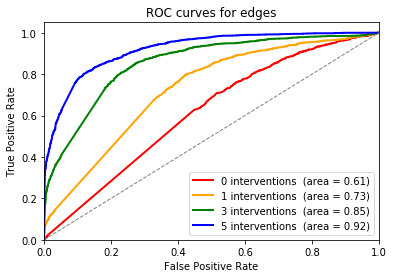

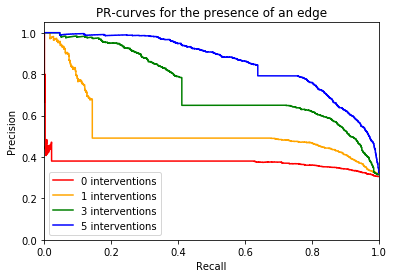

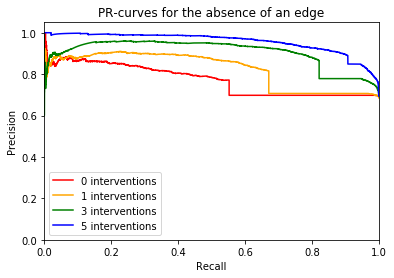

In [12]:
for s in range(len(inx)):
    k = inx[s]
    fpr,tpr,roc_auc,prec0,rec0,prec1,rec1,ap0,ap1 = roc_pr_stats(filenameprefix+str(k)+"/",
                                                                 edge_type='edge',sep='s',m=0)
    plt.figure(0)
    plt.plot(fpr, tpr, color=col[s],lw=2, label='%d interventions  (area = %0.2f)' % (k,roc_auc))    
    plt.figure(1)
    plt.step(rec1, prec1, color=col[s], alpha=1,where='post',label='%d interventions' %k) 
    plt.figure(2)
    plt.step(rec0, prec0, color=col[s], alpha=1,where='post',label='%d interventions' %k) 

plt.figure(0)    
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for edges')
plt.legend(loc="lower right")
plt.savefig("../plots/ROC_edges_intv.pdf" , transparent=True, format='pdf', bbox_inches="tight")

plt.figure(1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.title('PR-curves for the presence of an edge') 
plt.savefig("../plots/PR_edges_1_intv.pdf" , transparent=True, format='pdf', bbox_inches="tight")

plt.figure(2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.title('PR-curves for the absence of an edge') 
plt.savefig("../plots/PR_edges_0_intv.pdf" , transparent=True, format='pdf', bbox_inches="tight")

### ROC/PR curves for confounders (vs. number of interventions) ###

300
300
300
300


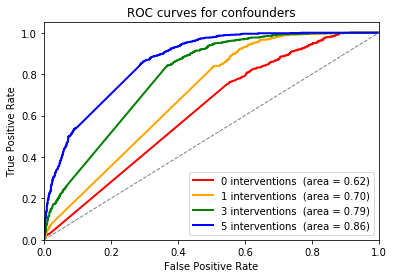

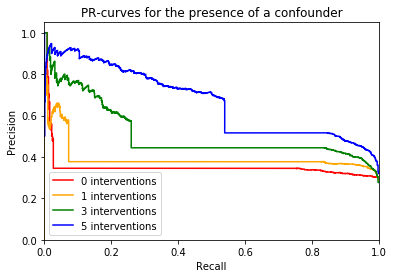

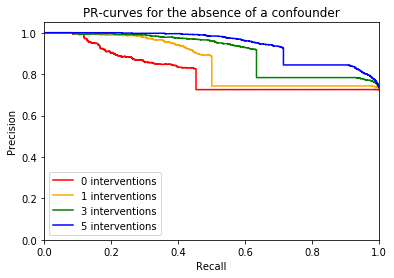

In [13]:
for s in range(len(inx)):
    k = inx[s]
    fpr,tpr,roc_auc,prec0,rec0,prec1,rec1,ap0,ap1 = roc_pr_stats(filenameprefix+str(k)+"/",
                                                                 edge_type='conf',sep='s',m=0)
    plt.figure(0)
    plt.plot(fpr, tpr, color=col[s],lw=2, label='%d interventions  (area = %0.2f)' % (k,roc_auc))
    plt.figure(1)
    plt.step(rec1, prec1, color=col[s], alpha=1,where='post',label='%d interventions' %k)
    plt.figure(2)
    plt.step(rec0, prec0, color=col[s], alpha=1,where='post',label='%d interventions' %k)
    
plt.figure(0)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for confounders')
plt.legend(loc="lower right")
plt.savefig("../plots/ROC_confs_intv.pdf", transparent=True, format='pdf', bbox_inches="tight")

plt.figure(1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.title('PR-curves for the presence of a confounder') 
plt.savefig("../plots/PR_confs_1_intv.pdf", transparent=True, format='pdf', bbox_inches="tight")

plt.figure(2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.title('PR-curves for the absence of a confounder') 
plt.savefig("../plots/PR_confs_0_intv.pdf", transparent=True, format='pdf', bbox_inches="tight")

### ROC/PR curves for edges (vs. encoding) ###

In [14]:
col = ['blue','green','red']
inx = ['a','d','s'] 
labels = ['d-separation (acyclic)','d-separation','sigma-separation']
k=5

300
300
300


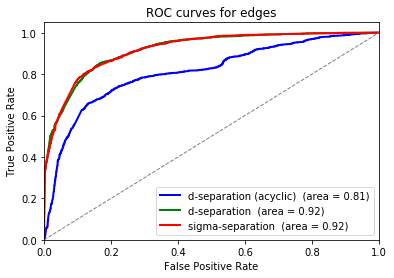

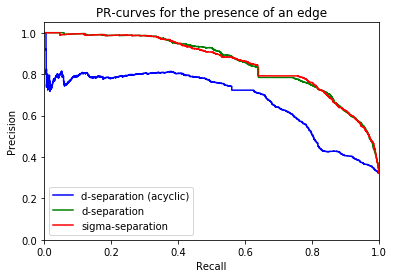

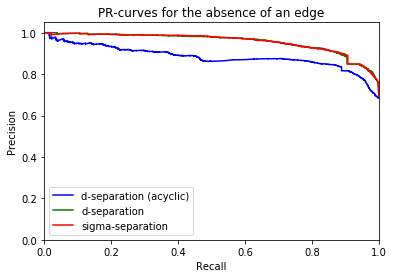

In [15]:
for s in range(len(inx)):
    fpr,tpr,roc_auc,prec0,rec0,prec1,rec1,ap0,ap1 = roc_pr_stats(filenameprefix+str(k)+"/",
                                                                 edge_type='edge',sep=inx[s],m=0)
    plt.figure(0)
    plt.plot(fpr, tpr, color=col[s],lw=2, label='%s  (area = %0.2f)' % (labels[s],roc_auc))    
    plt.figure(1)
    plt.step(rec1, prec1, color=col[s], alpha=1,where='post',label='%s' %labels[s])    
    plt.figure(2)
    plt.step(rec0, prec0, color=col[s], alpha=1,where='post',label='%s' %labels[s]) 
    
plt.figure(0)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for edges')
plt.legend(loc="lower right")
plt.savefig("../plots/ROC_edges_encoding.pdf" , transparent=True, format='pdf', bbox_inches="tight")

plt.figure(1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.title('PR-curves for the presence of an edge') 
plt.savefig("../plots/PR_edges_1_encoding.pdf" , transparent=True, format='pdf', bbox_inches="tight")

plt.figure(2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.title('PR-curves for the absence of an edge') 
plt.savefig("../plots/PR_edges_0_encoding.pdf" , transparent=True, format='pdf', bbox_inches="tight")

### ROC/PR curves for confounders (vs. encoding) ###

300
300
300


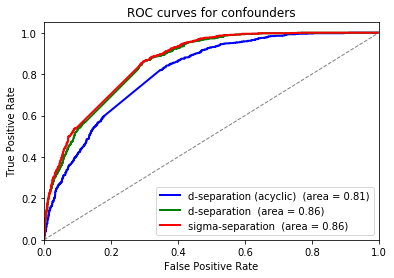

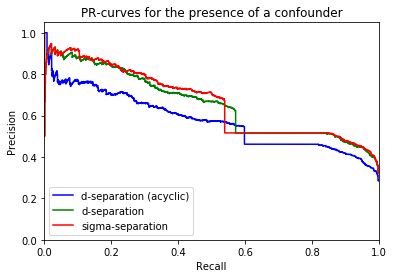

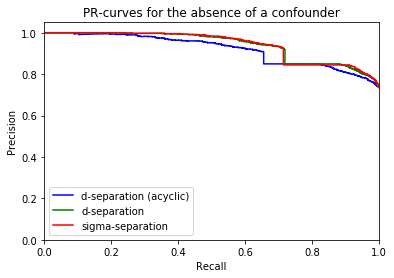

In [16]:
for s in range(len(inx)):
    fpr,tpr,roc_auc,prec0,rec0,prec1,rec1,ap0,ap1 = roc_pr_stats(filenameprefix+str(k)+"/",
                                                                 edge_type='conf',sep=inx[s],m=0)
    plt.figure(0)
    plt.plot(fpr, tpr, color=col[s],lw=2, label='%s  (area = %0.2f)' % (labels[s],roc_auc))
    plt.figure(1)
    plt.step(rec1, prec1, color=col[s], alpha=1,where='post',label=labels[s])
    plt.figure(2)
    plt.step(rec0, prec0, color=col[s], alpha=1,where='post',label=labels[s])

plt.figure(0)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for confounders')
plt.legend(loc="lower right")
plt.savefig("../plots/ROC_confs_encoding.pdf", transparent=True, format='pdf', bbox_inches="tight")

plt.figure(1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-curves for the presence of a confounder')
plt.legend(loc="lower left")
plt.savefig("../plots/PR_confs_1_encoding.pdf", transparent=True, format='pdf', bbox_inches="tight")

plt.figure(2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-curves for the absence of a confounder')
plt.legend(loc="lower left")
plt.savefig("../plots/PR_confs_0_encoding.pdf", transparent=True, format='pdf', bbox_inches="tight")